# Person Detection

I employed a pre-trained TensorFlow model, specifically the Faster R-CNN with Inception ResNet v2 architecture trained on the COCO dataset, for person detection in my project. This model allows me to detect all objects which I then filter for person. 

In [1]:
from numpyencoder import NumpyEncoder
import json
import cv2
import re
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow import lite
import tensorflow_hub as hub
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.neighbors import NearestNeighbors


## Download the Model from Kaggle

In [2]:
model_url = "https://kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1"
model = hub.load(model_url)

The predictions generated include essential information such as detection boxes (boxes), detection scores (scores), and detected classes (classes). Subsequently, the code filters the boxes specifically where persons are detected, identified by the condition classes == 1. To refine the selection further, a confidence threshold of 0.70 is established, ensuring that only boxes with scores surpassing this threshold are retained. Finally, the function returns the chosen boxes along with their corresponding scores.

In [3]:
def predict_and_filter(input_tensor):
    predictions = model(input_tensor)

    boxes = (predictions['detection_boxes']).numpy()
    scores = (predictions['detection_scores']).numpy()
    classes = (predictions['detection_classes']).numpy()

    class_1_indices=[]
    class_1_boxes=[]

    class_1_indices = np.where(classes == 1)
    class_1_boxes = boxes[class_1_indices]
    class_1_scores = scores[class_1_indices]

    confidence_threshold = 0.50
    selected_indices = np.where(class_1_scores > confidence_threshold)
    selected_boxes = class_1_boxes[selected_indices]
    selected_scores = class_1_scores[selected_indices]

    return selected_boxes, selected_scores

With this method i can plot boxes around people in frame from the viedo and display the scores  

In [4]:
def display_image_with_boxes(image, boxes, scores):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Größe des Originalbildes
    img_height, img_width, _ = image.shape

    for box, score in zip(boxes, scores):
        ymin, xmin, ymax, xmax = box
        ymin = int(ymin * img_height)
        xmin = int(xmin * img_width)
        ymax = int(ymax * img_height)
        xmax = int(xmax * img_width)

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 5, f'Score: {score.item():.2f}', color='r')

    plt.show()

This script loads a video, skips frames, performs person detection, displays the frames with bounding boxes, and saves individual images of detected persons in a specified output folder.

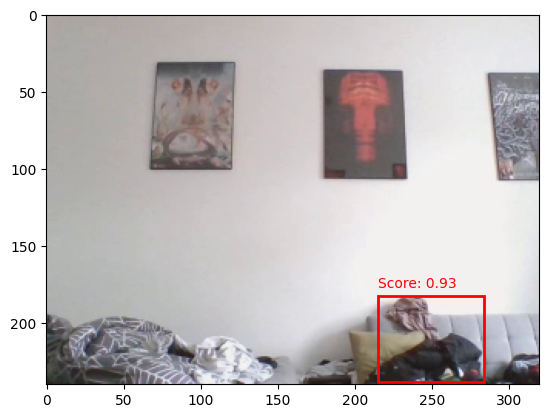

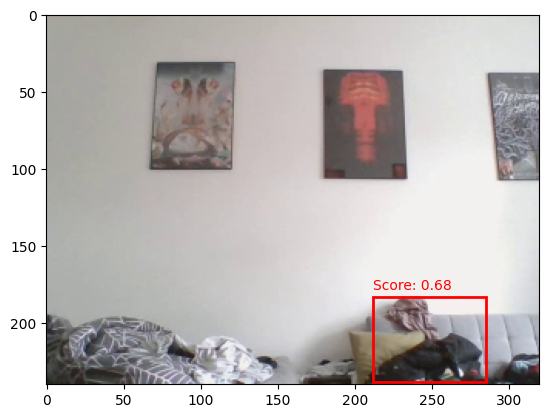

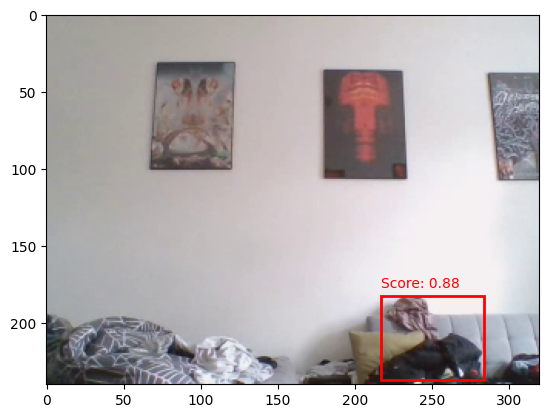

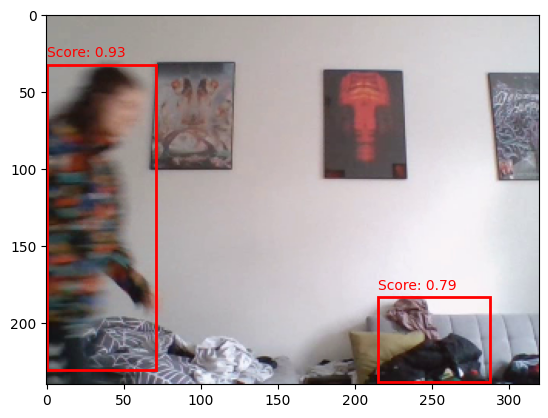

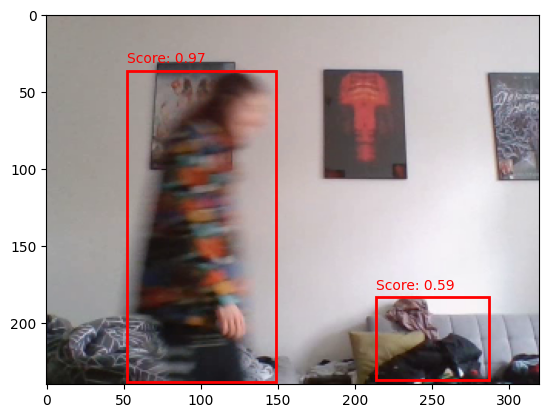

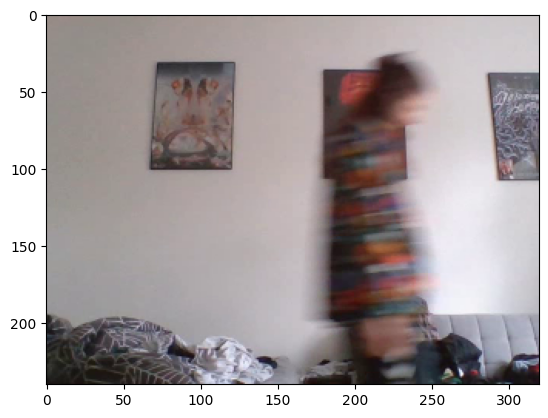

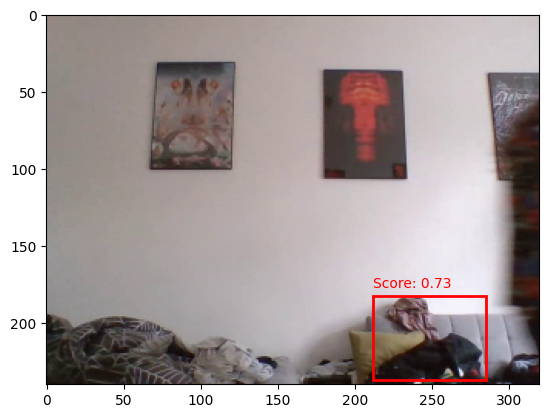

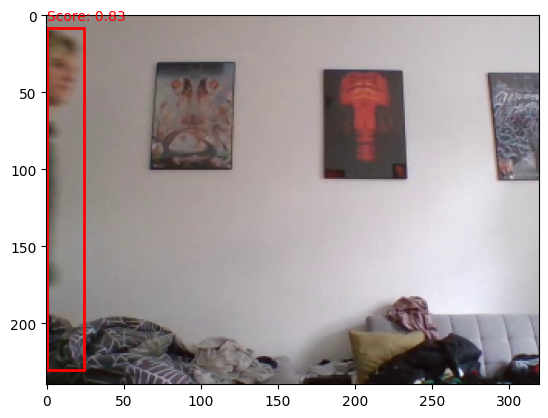

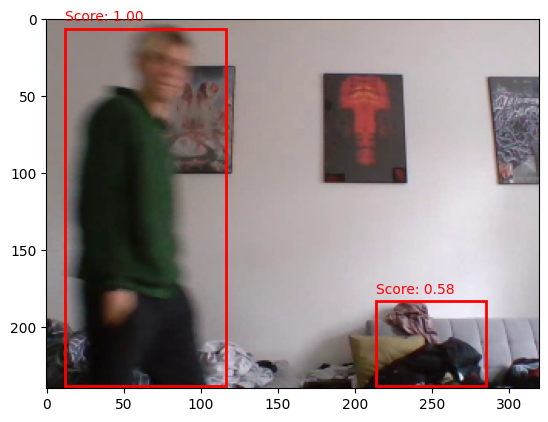

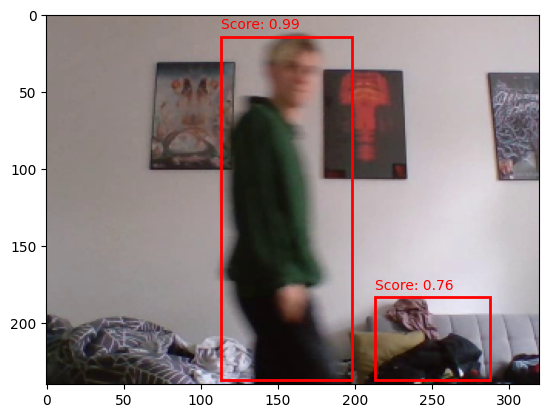

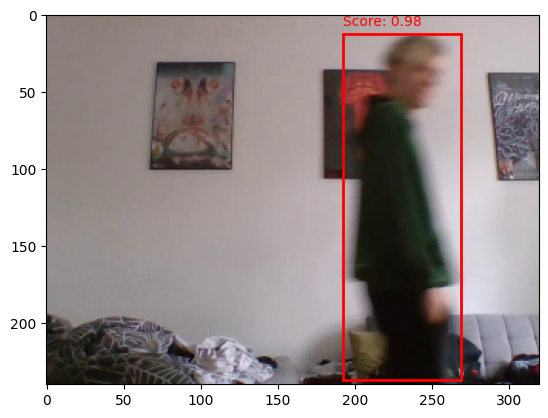

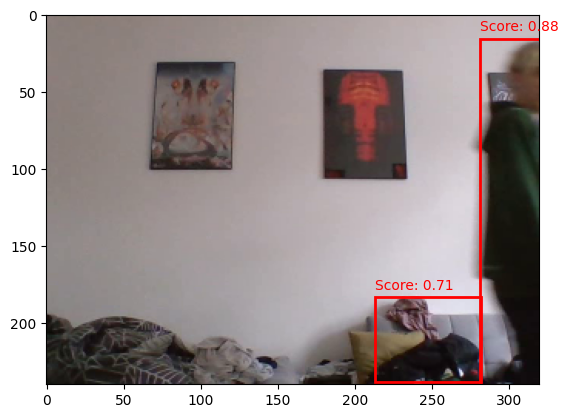

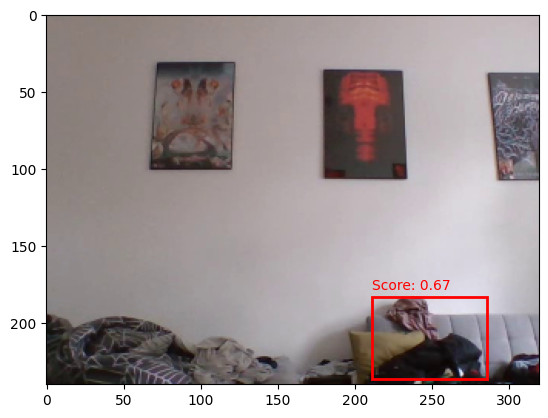

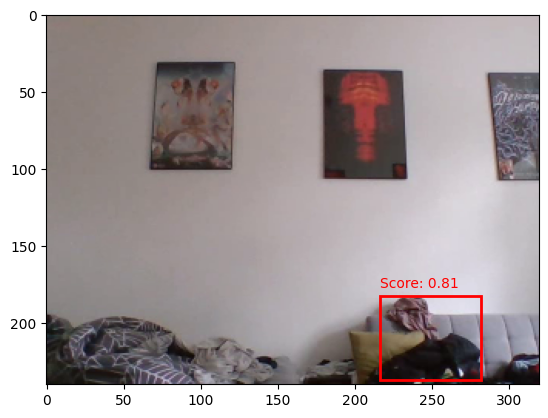

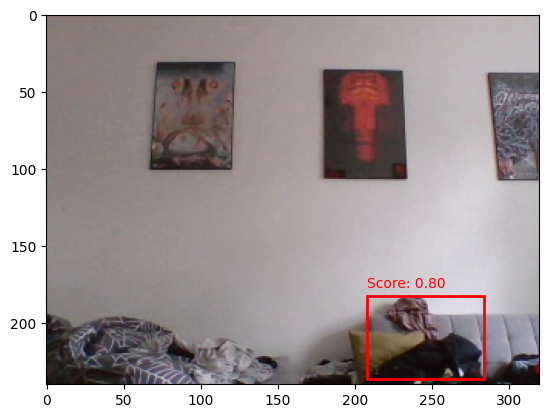

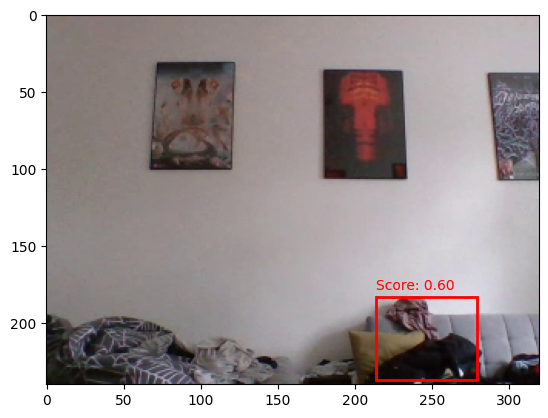

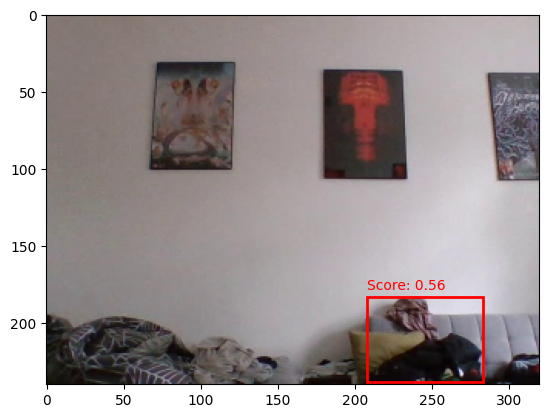

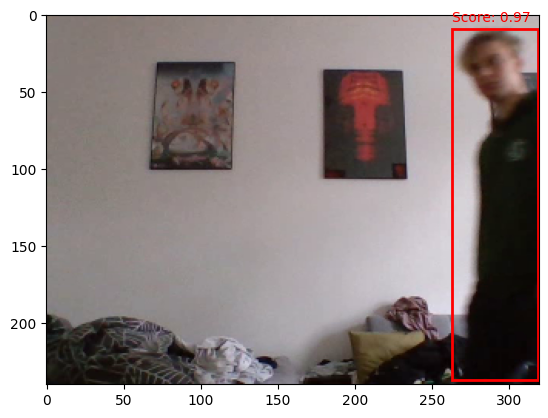

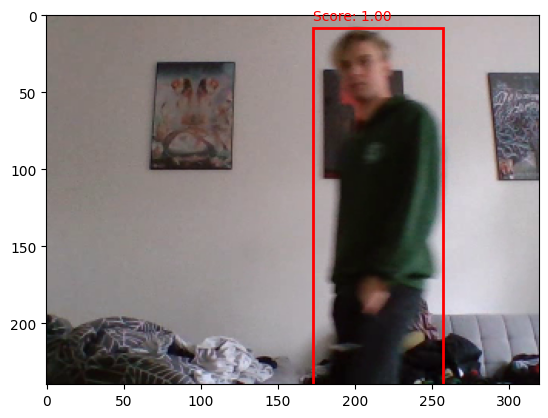

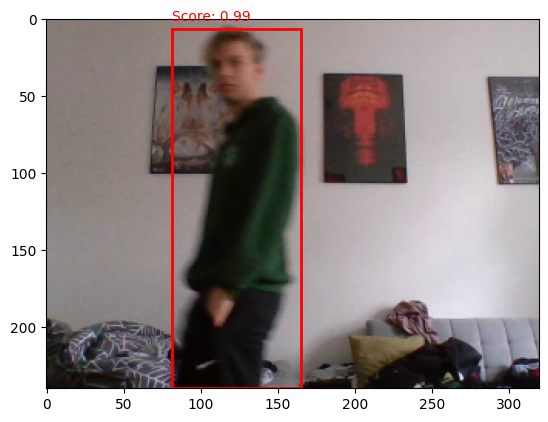

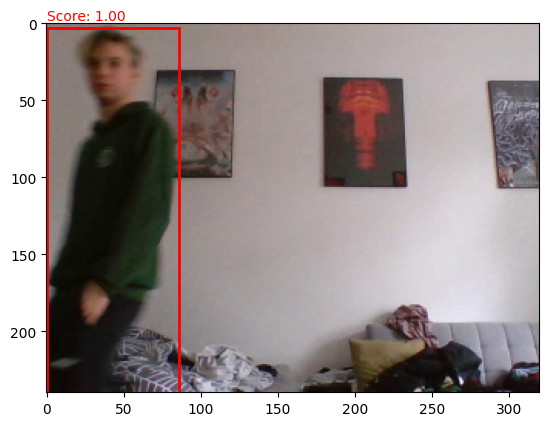

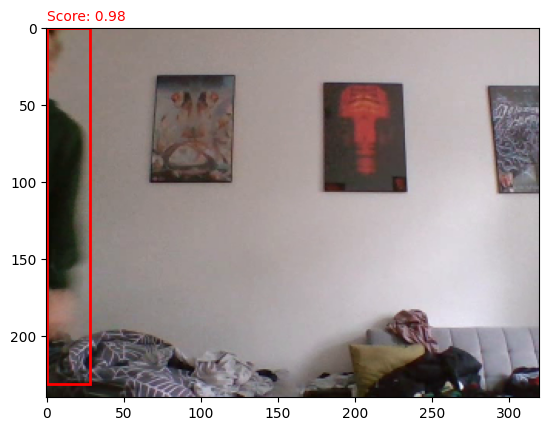

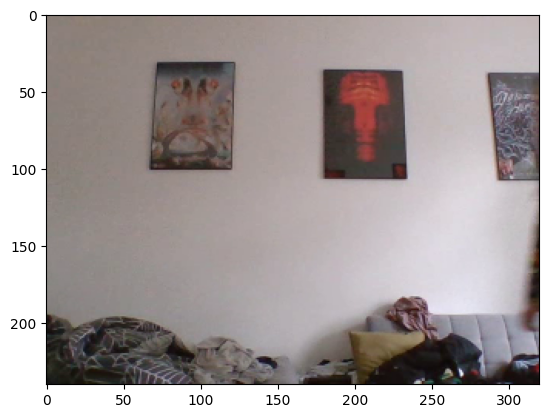

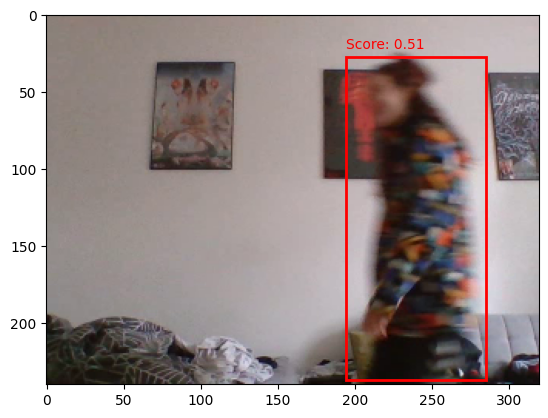

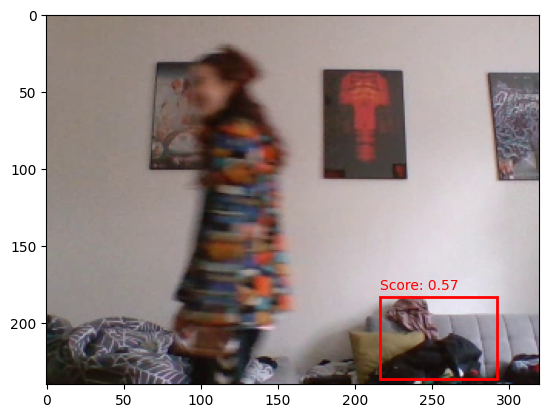

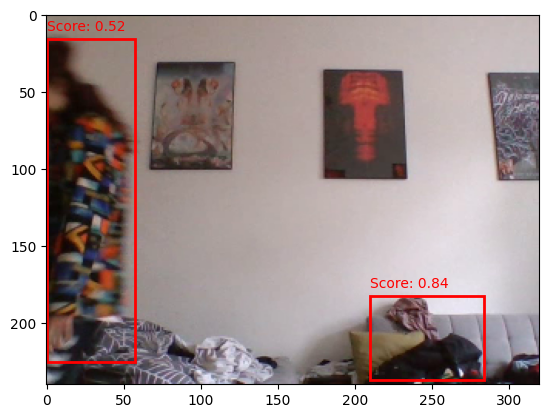

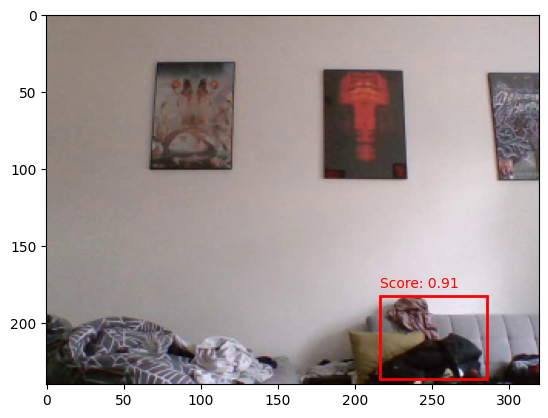

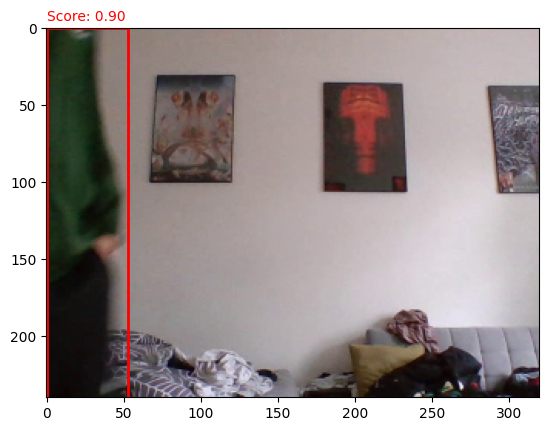

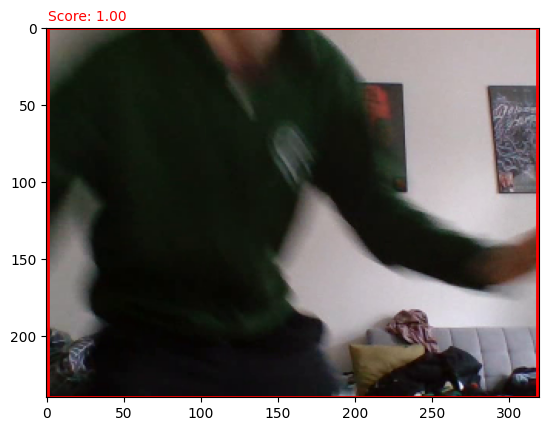

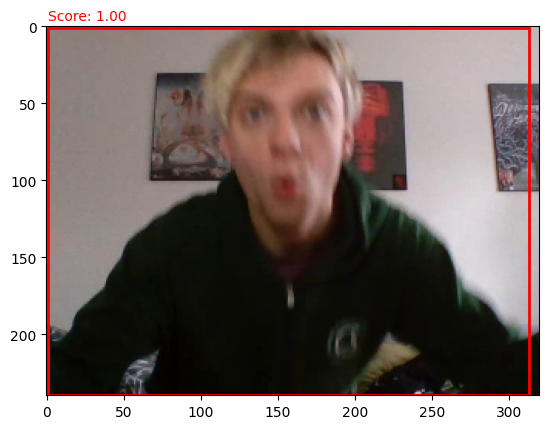

In [6]:
video_path = "./Video/test_video2.mp4"
cap = cv2.VideoCapture(video_path)

output_folder = "detected_persons"
os.makedirs(output_folder, exist_ok=True)

# Konfiguration des Video-Writers
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
# Iterate through the frames
frame_count = 50 # i start here at 50 because the test_video2.mp4 is not interesting at the beginning and i want to skip it
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # Process only every 20 frames
    if frame_count % 20 == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        target_height = 240  # Ihre gewünschte Höhe
        target_width = 320   # Ihre gewünschte Breite
        resized_frame = cv2.resize(frame_rgb, (target_width, target_height))
        tf_frame = tf.convert_to_tensor(resized_frame, dtype=tf.uint8)
        tf_frame = tf_frame[tf.newaxis, ...]

        tf_boxes, tf_scores = predict_and_filter(tf_frame)
        display_image_with_boxes(resized_frame, tf_boxes, tf_scores)

        # Draw the bounding boxes in the frame
        i = 0
        for box, score in zip(tf_boxes, tf_scores):
            ymin, xmin, ymax, xmax = box
            ymin = int(ymin * frame_height)
            xmin = int(xmin * frame_width)
            ymax = int(ymax * frame_height)
            xmax = int(xmax * frame_width)

            cropped_box = frame[ymin:ymax, xmin:xmax]
            box_filename = os.path.join(output_folder, f"Person_fram-{frame_count}_personId-{i}.png")
            cv2.imwrite(box_filename, cropped_box)

    frame_count += 1

cap.release()
cv2.destroyAllWindows()